## Libraries

In [1]:
### Load Libraries and Functions
import os
import pickle
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

from collections import Counter

from _cm import lambda_path, eln, bss, crr, dtr, candidate_models, candidate_models_kf
from _fm import bssf_cv, fss_cv, lasso_cv, csr_cv, avg_best_cv, pelasso_cv, psgd_cv
from _helpers import relevant_predictor, run_results
from _visualization import plot_subsetsize, plot_cm, plot_preds
from _simulation import sim_linear, sim_frd1, sim_frd2, sim_data

import gurobipy as gp
gp.setParam('OutputFlag', 0)

if os.name == 'nt':
    import dill
    dill.settings['recurse'] = True

Set parameter Username
Academic license - for non-commercial use only - expires 2025-06-10


In [2]:
# Set Path
path  =  os.path.dirname(os.getcwd())

## Simulation

In [3]:
### Parameter
# Setting
N = 5
train = 100
ran_st = 123
timeout = 5
alpha = 1e6
simulation_settings = [
    ('linear', 200, 100, 15, 1.0),
    ('frd1', 200, 100, None, 1.0),
    ('frd2', 200, 100, None, 1.0),
    ('comb1', 200, 100, 50, 1.0),
    ('comb2', 200, 100, 50, 1.0),
]

# Candidate Models
cm_params = [
    ("bss", {"k_vec": np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]), "n_jobs": 1}),
    #("eln", {"n_lambda": 20, "alpha_vec": np.array([0.0, 0.25, 0.50, 0.75, 1.00]), "n_jobs": 1}),
    #("crr", {"comp_vec": np.array([1, 2, 3, 4, 5]), "rep_range": np.arange(1, 501), "n_jobs": 1}),
    ("dtr", {"vec_depth": np.array([2, 3, 4, 5]), "n_jobs": 1}),
    #("dtrst", {"n_jobs": 1}),
]

In [4]:
# Loop over settings
for setting in simulation_settings:
    
    # Unpack setting tuple
    sim_type, n, p, s, snr = setting
    
    # Print or process each setting
    print(f"Running setting: Type={sim_type}, n={n}, p={p}, s={s}, snr={snr}, timeout={timeout}s, alpha={alpha}")
    
    # Generate Data
    X, y, indices = sim_data(sim_type, n, p, s, snr)
    
    # Run Results
    results = run_results(N, X, y, train, cm_params, timeout, alpha, ran_st)
    
    # Save Results
    filename = f"{path}/Results/Simulation/{sim_type}_{n}_{p}_{s}_{snr}.pkl"
    with open(filename, 'wb') as file:
        pickle.dump(results, file)

Running setting: Type=linear, n=200, p=100, s=15, snr=1.0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Running setting: Type=frd1, n=200, p=100, s=None, snr=1.0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Running setting: Type=frd2, n=200, p=100, s=None, snr=1.0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Running setting: Type=comb1, n=200, p=100, s=50, snr=1.0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Running setting: Type=comb2, n=200, p=100, s=50, snr=1.0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5


Setting: N=5, Type=linear, n=200, p=100, s=15, snr=1.0, CM=19, alpha=1000000.0, timeout=5
{'PHM': 1.2965, 'LASSO': 1.2156, 'PELASSO': 1.0506, 'AVG_BEST': 0.9737, 'CSR': 1.1625, 'PSGD': 1.1434, 'BSSF': 1.0}


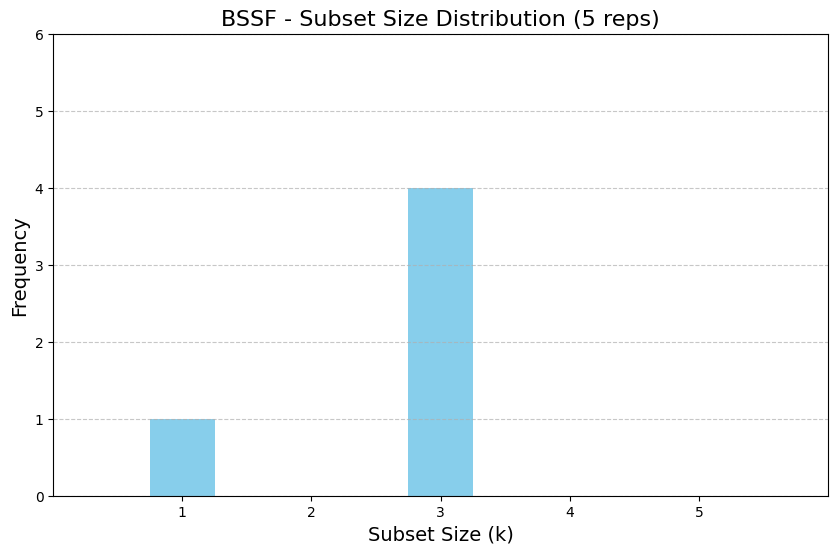

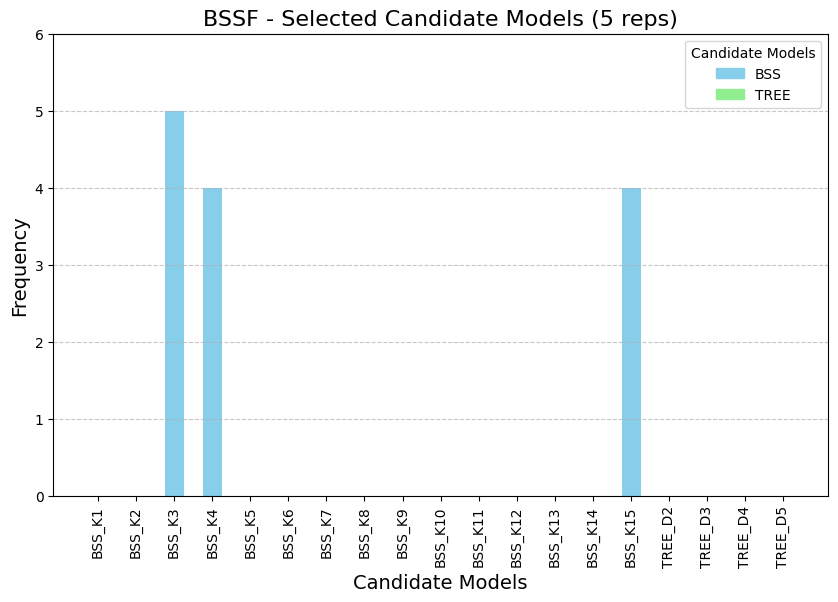

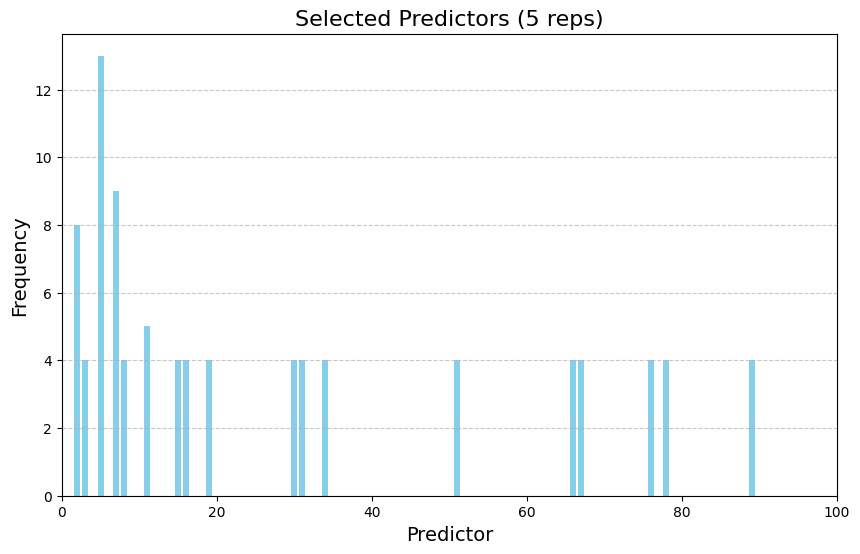

Setting: N=5, Type=frd1, n=200, p=100, s=None, snr=1.0, CM=19, alpha=1000000.0, timeout=5
{'PHM': 1.6067, 'LASSO': 1.0511, 'PELASSO': 1.2683, 'AVG_BEST': 1.0028, 'CSR': 1.5127, 'PSGD': 1.1637, 'BSSF': 1.0}


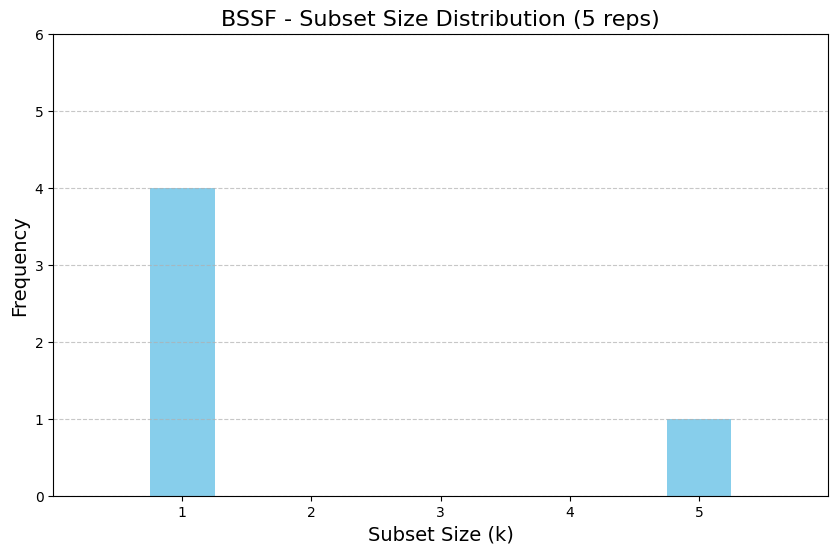

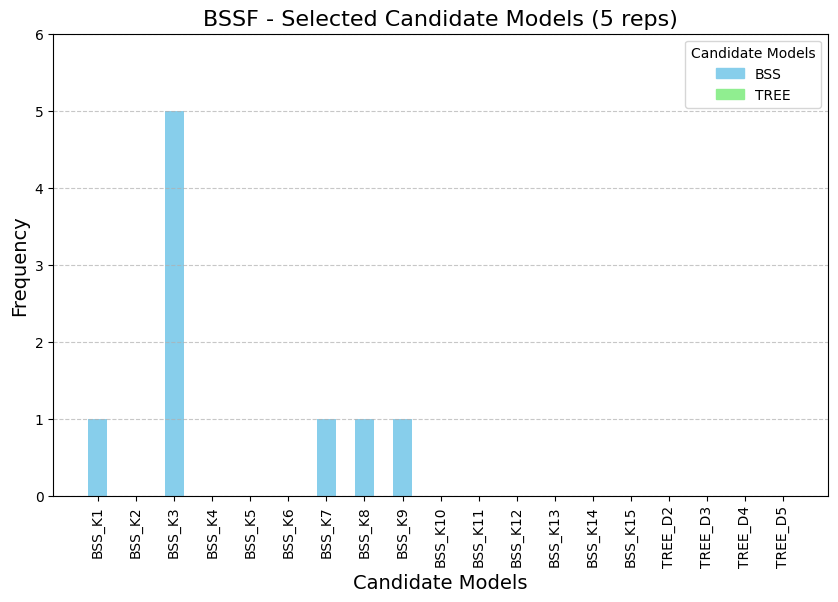

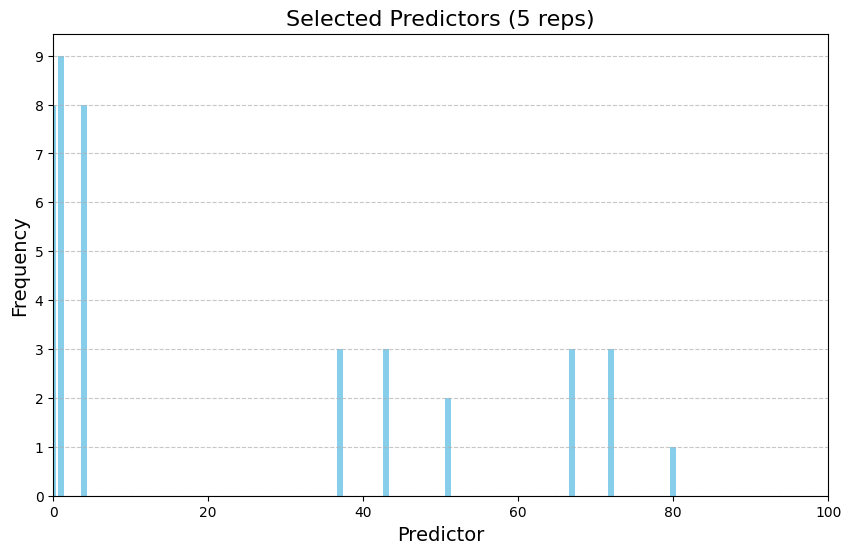

Setting: N=5, Type=frd2, n=200, p=100, s=None, snr=1.0, CM=19, alpha=1000000.0, timeout=5
{'PHM': 0.9679, 'LASSO': 0.943, 'PELASSO': 0.9576, 'AVG_BEST': 1.007, 'CSR': 0.9405, 'PSGD': 0.9176, 'BSSF': 1.0}


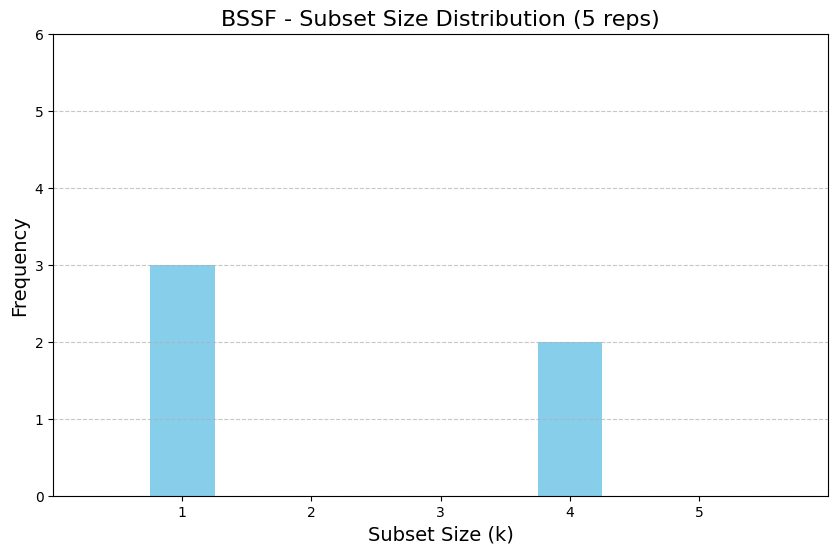

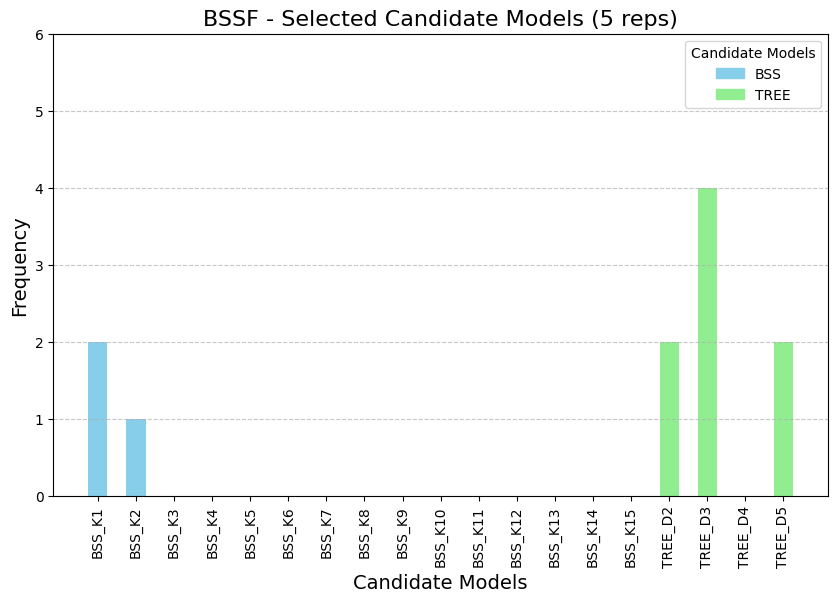

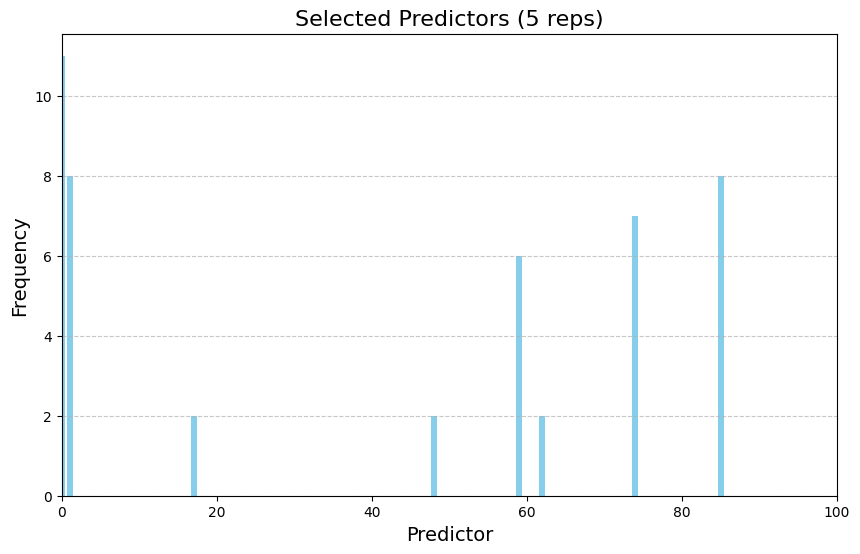

Setting: N=5, Type=comb1, n=200, p=100, s=50, snr=1.0, CM=19, alpha=1000000.0, timeout=5
{'PHM': 1.3035, 'LASSO': 1.0131, 'PELASSO': 1.2075, 'AVG_BEST': 0.9973, 'CSR': 1.1321, 'PSGD': 0.9075, 'BSSF': 1.0}


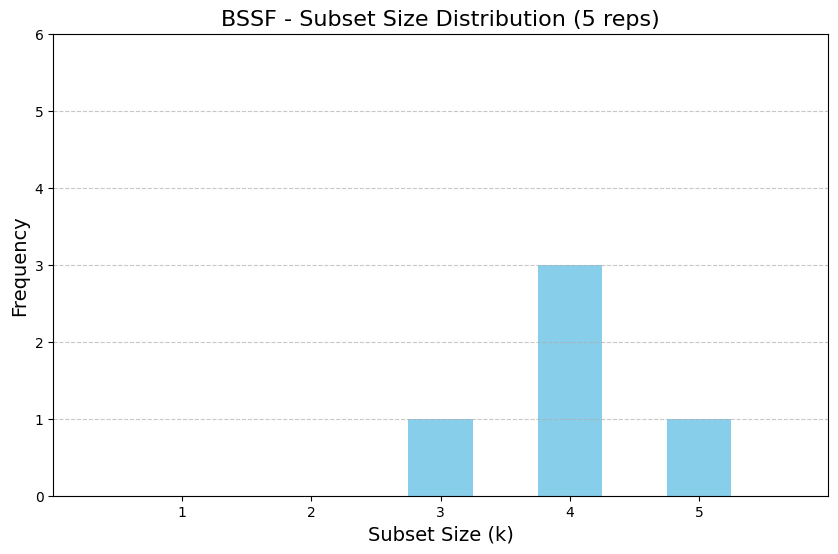

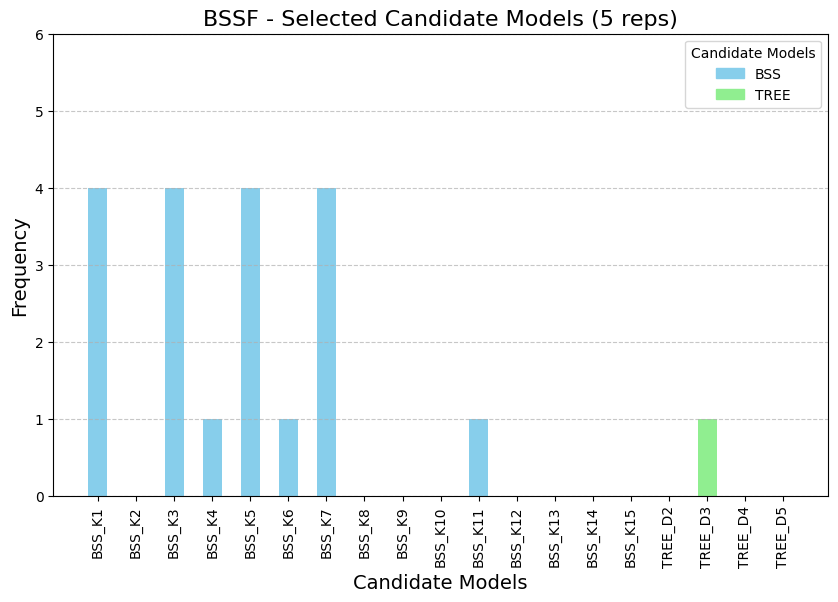

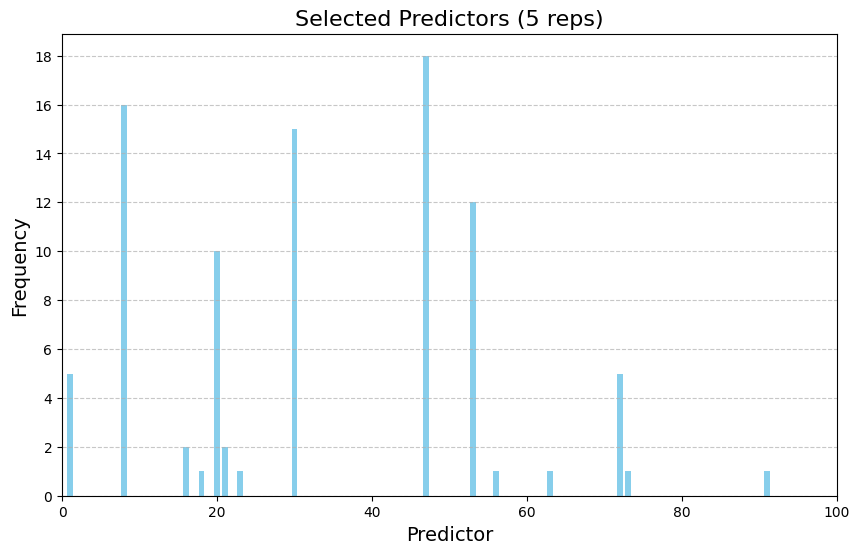

Setting: N=5, Type=comb2, n=200, p=100, s=50, snr=1.0, CM=19, alpha=1000000.0, timeout=5
{'PHM': 1.184, 'LASSO': 1.2402, 'PELASSO': 1.192, 'AVG_BEST': 1.1194, 'CSR': 1.0852, 'PSGD': 1.1212, 'BSSF': 1.0}


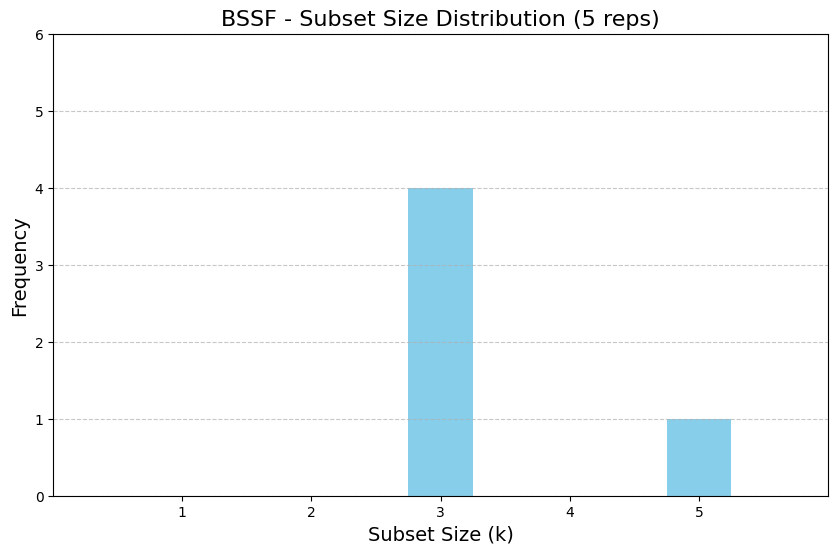

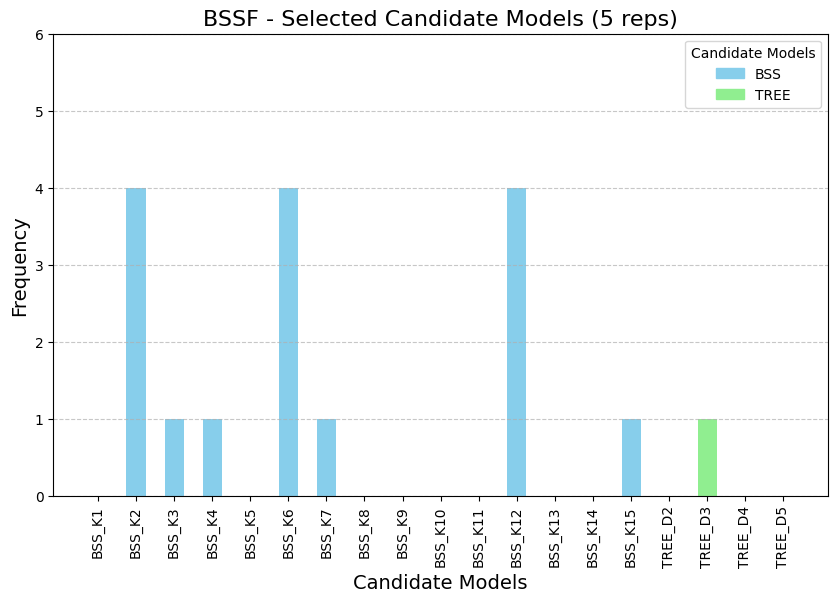

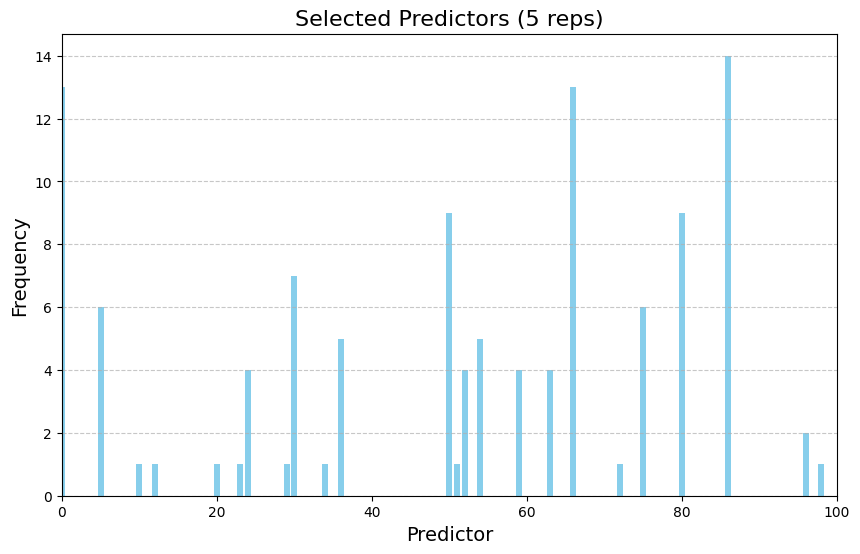

In [15]:
# Load Results
for setting in simulation_settings:
    
    # Unpack setting tuple
    sim_type, n, p, s, snr = setting
        
    # Load Results
    filename = f"{path}/Results/Simulation/{sim_type}_{n}_{p}_{s}_{snr}.pkl"
    with open(filename, 'rb') as file:
        results = pickle.load(file)
        
    # Assign Results
    preds = results['predictions']
    scores = results['mse']
    best_k = results['best_k']
    bssf_weights = results['bssf_weights']
    cf_models = results['cf_models']
    cf_descriptions = results['cf_descriptions']
    model_names = results['fmodel_names']
    bssf_timeout = results['bssf_timeout']
    bssf_alpha = results['bssf_alpha']
    runs = len(results['predictions'])
    numb_cm = len(cf_models[0])
    
    # Print Setting
    print(f"Setting: N={runs}, Type={sim_type}, n={n}, p={p}, s={s}, snr={snr}, CM={numb_cm}, alpha={bssf_alpha}, timeout={bssf_timeout}")
    
    # Relative to BSSF
    relative_scores = np.round(np.mean(scores, axis = 0) / np.mean(scores, axis = 0)[6], 4)
    
    # Show
    model_scores = {model: score for model, score in zip(model_names, relative_scores)}
    print(model_scores)
    
    # Plot Subset-Size
    plot_subsetsize(best_k, 5, runs)
    
    # Plot Selected Candidate Models
    plot_cm(bssf_weights, cf_descriptions, runs)
    
    # Plot Selected Predictiors
    plot_preds(cf_models, bssf_weights, p, runs)